Electricity Cost Prediction

Datasets downloaded from here: https://www.kaggle.com/datasets/shalmamuji/electricity-cost-prediction-dataset

In this project, we'll be:
1. Loading datasetes and performing Exploratory Data Analysis (EDA)
2. Preprocess the data (Including data cleaning)
3. Train the model
4. Test the result

In [58]:
import pandas as pd
import numpy as np
import sklearn
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import root_mean_squared_error
import seaborn as sns
%matplotlib inline

Loading and exploring data

In [ ]:
df = pd.read_csv("electricity_cost_dataset.csv")

# Column name shouldn't contain space, at least it's not the best practice, therefore I'll replace it with underscore
for col in df.columns:
    newColName = col.replace(' ', '_')
    df.rename(columns={col: newColName}, inplace=True)

# This is a mistake from imported dataset
df.rename(columns={"issue_reolution_time": "issue_resolution_time"}, inplace=True)
df.rename(columns={"air_qality_index": "air_quality_index"}, inplace=True)
df.rename(columns={"issue reolution time": "issue_resolution_time"}, inplace=True)

df.head()

,site_area,structure_type,water_consumption,recycling_rate,utilisation_rate,air_quality_index,issue_resolution_time,resident_count,electricity_cost
0,1360,Mixed-use,2519.0,69,52,188,1,72,1420.0
1,4272,Mixed-use,2324.0,50,76,165,65,261,3298.0
2,3592,Mixed-use,2701.0,20,94,198,39,117,3115.0
3,966,Residential,1000.0,13,60,74,3,35,1575.0
4,4926,Residential,5990.0,23,65,32,57,185,4301.0


In [3]:
df.shape

(10000, 9)

In [4]:
df["structure_type"].unique()

array(['Mixed-use', 'Residential', 'Commercial', 'Industrial'],
      dtype=object)

In [5]:
df["structure_type"].value_counts() # As we can see the categories are slightly imabalanced so if it has high impact of electricity cost, it may underfit the smaller classes

structure_type
Residential    3939
Commercial     3005
Mixed-use      2052
Industrial     1004
Name: count, dtype: int64

In [6]:
cols = df.columns.drop("structure_type")

for col in cols:
    print(f"====={col}=====")
    print("Min:", df[col].min())
    print("Max:", df[col].max())
    print("Median:", df[col].median())
    print("Mean:", df[col].mean())
    print("STD:", df[col].std())
    print()

=====site_area=====
Min: 501
Max: 5000
Median: 2773.5
Mean: 2757.7751
STD: 1293.0599586738686

=====water_consumption=====
Min: 1000.0
Max: 10894.0
Median: 3047.5
Mean: 3494.0571
STD: 2076.1811173505325

=====recycling_rate=====
Min: 10
Max: 90
Median: 49.0
Mean: 49.598
STD: 23.430140698453204

=====utilisation_rate=====
Min: 30
Max: 100
Median: 65.0
Mean: 64.8422
STD: 20.43296478157243

=====air_quality_index=====
Min: 0
Max: 200
Median: 100.0
Mean: 99.4686
STD: 58.01452561693711

=====issue_resolution_time=====
Min: 1
Max: 72
Median: 36.0
Mean: 36.4026
STD: 20.6239047657028

=====resident_count=====
Min: 0
Max: 489
Median: 39.0
Mean: 85.5731
STD: 107.87617894320853

=====electricity_cost=====
Min: 500.0
Max: 6446.0
Median: 2760.0
Mean: 2837.845
STD: 1106.9974406060483



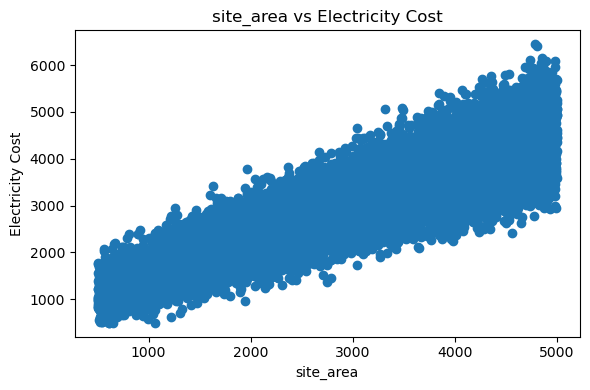

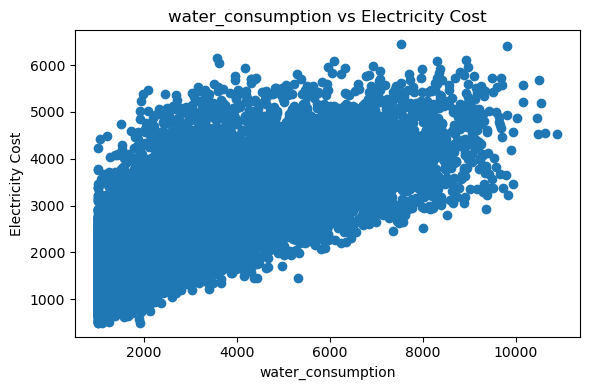

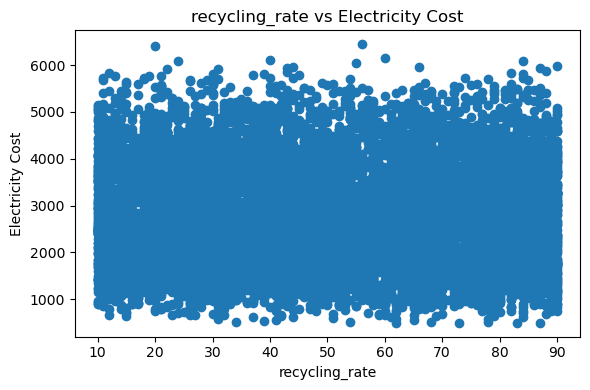

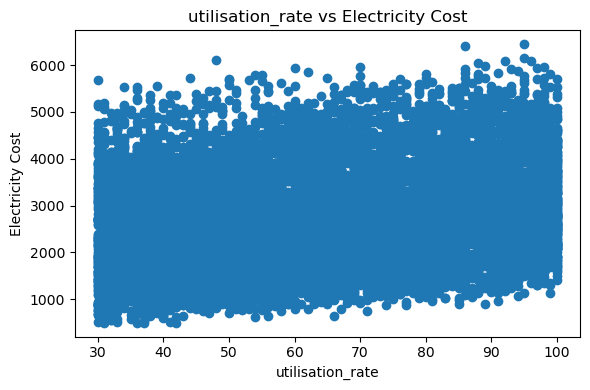

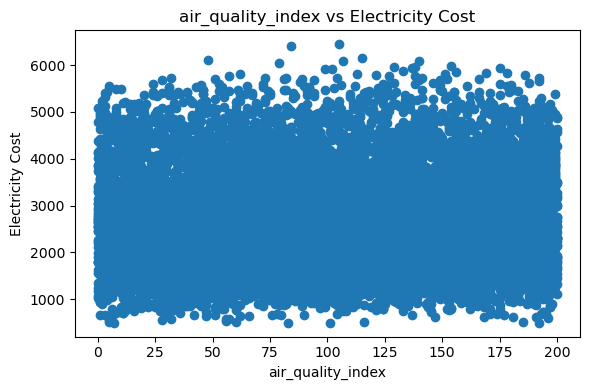

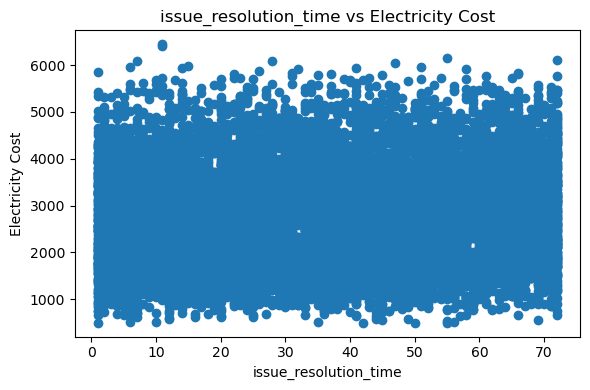

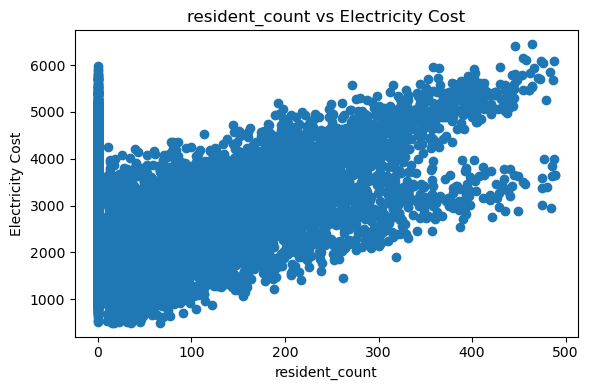

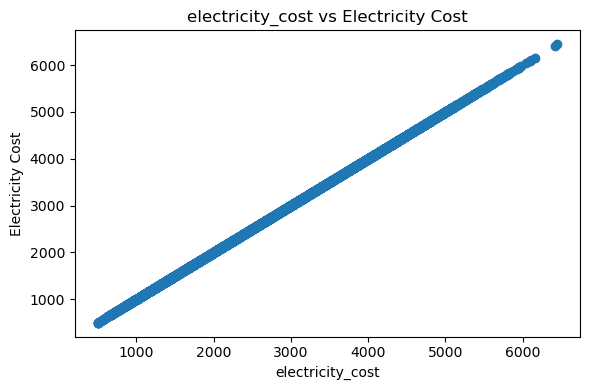

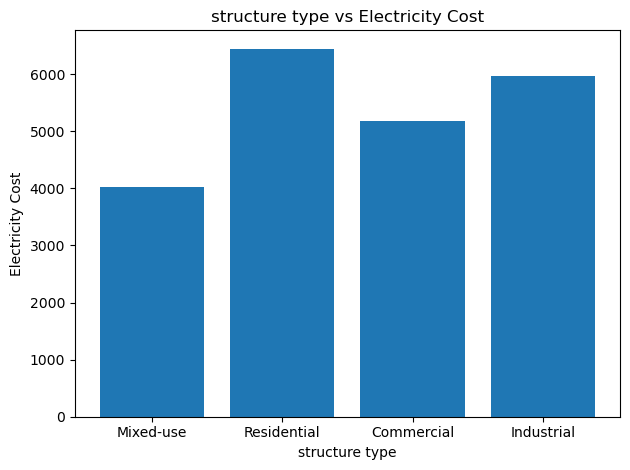

In [7]:
# Visualizing each feature against electricity cost
for col in cols:
    plt.figure(figsize=(6, 4))
    plt.scatter(df[col], df["electricity_cost"])
    plt.title(f"{col} vs Electricity Cost")
    plt.xlabel(col)
    plt.ylabel("Electricity Cost")
    plt.tight_layout()
    plt.show()

plt.bar(df["structure_type"], df["electricity_cost"])
plt.title(f"structure type vs Electricity Cost")
plt.xlabel("structure type")
plt.ylabel("Electricity Cost")
plt.tight_layout()
plt.show()

As we can see here, features like "issue resolution time", "air quality index", "utilisation rate", and "recycling rate" are especially noisy and very scattered, meaning there are no trends. I'm going to perform further trend investigations, and if there are truly no trends appearing, I'll drop the scattered feature.

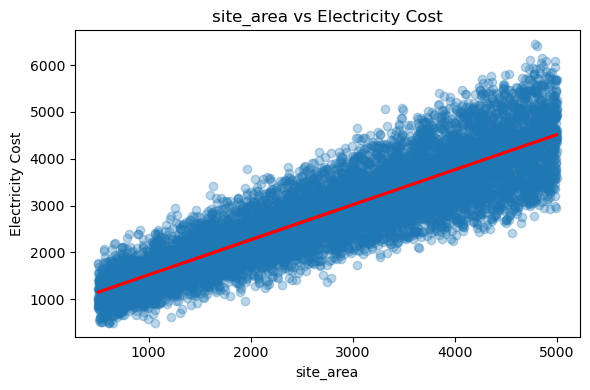

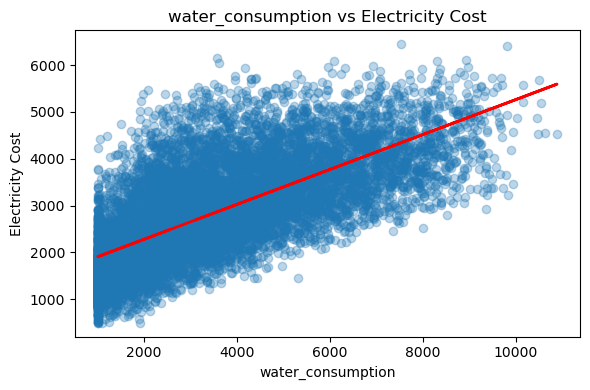

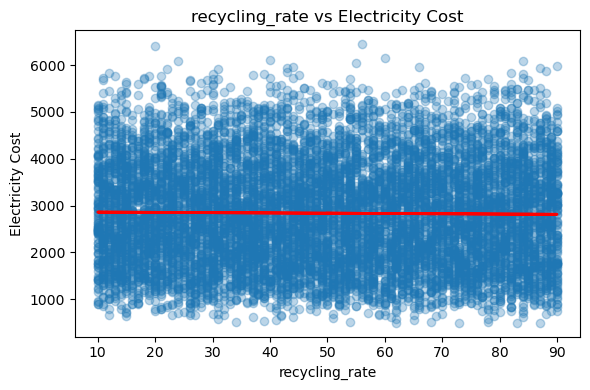

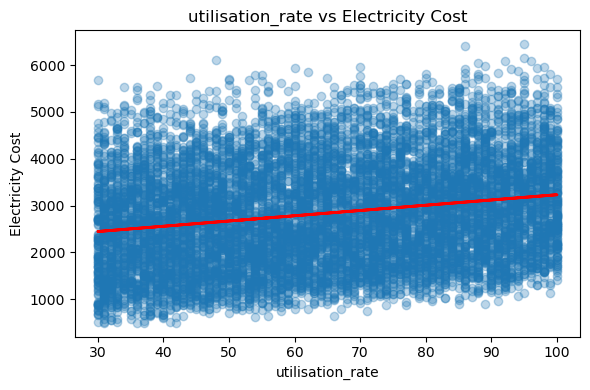

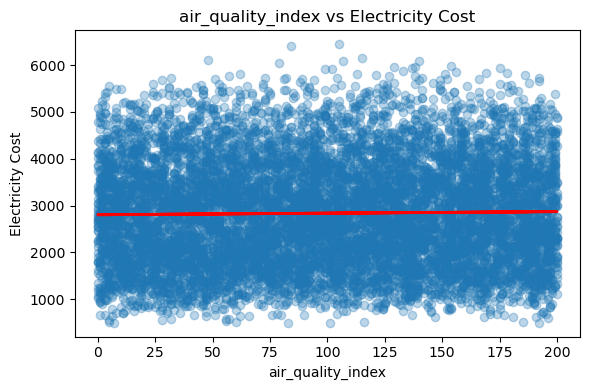

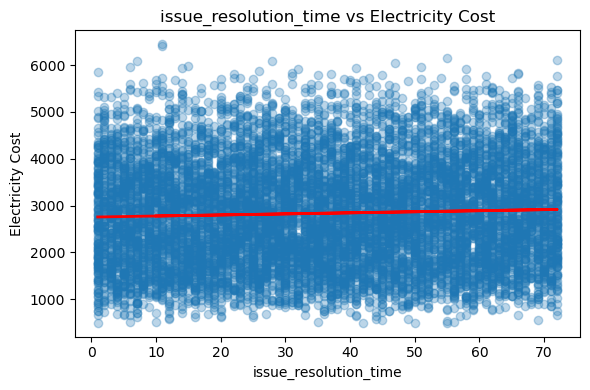

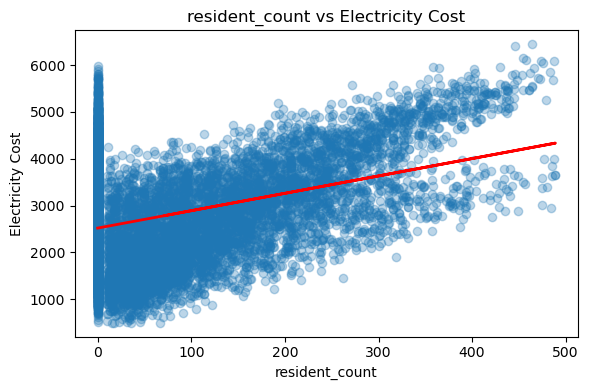

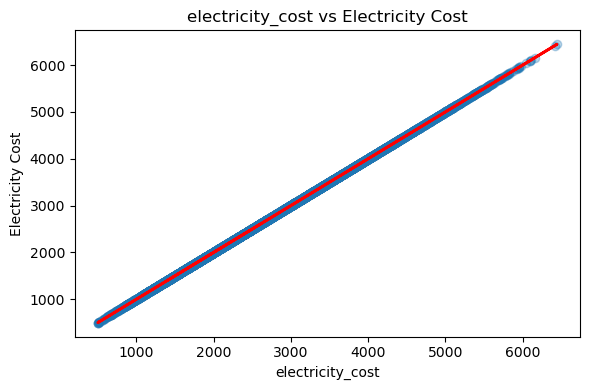

In [8]:
for col in cols:
    plt.figure(figsize=(6, 4))
    plt.scatter(df[col], df["electricity_cost"], alpha=0.3)
    
    # Regression line using polyfit
    z = np.polyfit(df[col], df["electricity_cost"], 1)
    p = np.poly1d(z)
    plt.plot(df[col], p(df[col]), color='red', linewidth=2)
    
    plt.title(f"{col} vs Electricity Cost")
    plt.xlabel(col)
    plt.ylabel("Electricity Cost")
    plt.tight_layout()
    plt.show()

In [51]:
corrs = df.corr(numeric_only=True)["electricity_cost"]
corrs

site_area                0.874376
water_consumption        0.698775
recycling_rate          -0.012536
utilisation_rate         0.207215
air_quality_index        0.017376
issue_resolution_time    0.042325
resident_count           0.361609
electricity_cost         1.000000
Name: electricity_cost, dtype: float64

As we can see, the visualization above and the correlation data confirmed the low correlation of the 4 features. Though "utilisation_rate" have more correlation than the other 3, it's still relatively low. I think "resident_count" should be kept as it has nearly 0.4 points on correlation.

In [16]:
# Removing uncorrelated data
df2 = df.drop(columns=["issue_resolution_time", "air_quality_index", "utilisation_rate", "recycling_rate"])
df2

,site_area,structure_type,water_consumption,resident_count,electricity_cost
0,1360,Mixed-use,2519.0,72,1420.0
1,4272,Mixed-use,2324.0,261,3298.0
2,3592,Mixed-use,2701.0,117,3115.0
3,966,Residential,1000.0,35,1575.0
4,4926,Residential,5990.0,185,4301.0
...,...,...,...,...,...
9995,708,Commercial,1365.0,0,885.0
9996,2960,Residential,3332.0,54,3081.0
9997,3942,Commercial,2427.0,0,3325.0
9998,3211,Commercial,4639.0,0,2892.0


Data Cleaning and Preprocessing

In [17]:
# One hot encode
df2 = pd.get_dummies(df2, columns=["structure_type"], drop_first=False)
df2.head()

,site_area,water_consumption,resident_count,electricity_cost,structure_type_Commercial,structure_type_Industrial,structure_type_Mixed-use,structure_type_Residential
0,1360,2519.0,72,1420.0,False,False,True,False
1,4272,2324.0,261,3298.0,False,False,True,False
2,3592,2701.0,117,3115.0,False,False,True,False
3,966,1000.0,35,1575.0,False,False,False,True
4,4926,5990.0,185,4301.0,False,False,False,True


In [18]:
# Splitting
X = df2.drop(columns=["electricity_cost"])
y = df2["electricity_cost"]
X.shape

(10000, 7)

In [ ]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

dtype('float64')

Here I'll try using a simple linear regression model as a linear relationship can be seen in the simple graph visualization

In [61]:
lr = LinearRegression()
y_pred = lr.fit(X_train, y_train)

score_train = lr.score(X_train, y_train) # Score on traiing data
score_test = lr.score(X_test, y_test) # Score on testing data

sample_pred = lr.predict(X_test[:5])
true_pred = y_test[:5]

for pred, actual in zip(sample_pred, true_pred):
    print(f"Predicted: {pred}")
    print(f"Actual: {actual}")
    print()

print(f"RMSE: {root_mean_squared_error(true_pred, sample_pred)}")
print(score_train)
print(score_test)

Predicted: 1286.9123148724038
Actual: 1480.0

Predicted: 1746.73133420004
Actual: 1796.0

Predicted: 786.2850547742319
Actual: 1522.0

Predicted: 1748.7347522641035
Actual: 1847.0

Predicted: 2289.251539786823
Actual: 2015.0

RMSE: 364.9264863487542
0.8859464673364743
0.8778115240721194


As we can see, the accuracy on training data and testing data are 0.88 and 0.877, there are minimal difference in terms of accuracy, which means there are no overfitting or underfitting issuess

Linear regression results seems pretty good, but let's see if other model does better. This time I'm trying random forest regressor because there are categorical features, which emans the model can try to form a condition from the dataset to predict data

In [62]:
rfr = RandomForestRegressor(100)
y_pred = rfr.fit(X_train, y_train)

score_train = rfr.score(X_train, y_train) # Score on traiing data
score_test = rfr.score(X_test, y_test) # Score on testing data

sample_pred = rfr.predict(X_test[:5])
true_pred = y_test[:5]

for pred, actual in zip(sample_pred, true_pred):
    print(f"Predicted: {pred}")
    print(f"Actual: {actual}")
    print()

print(f"RMSE: {root_mean_squared_error(true_pred, sample_pred)}")
print(score_train)
print(score_test)

Predicted: 1715.13
Actual: 1480.0

Predicted: 1569.31
Actual: 1796.0

Predicted: 1208.45
Actual: 1522.0

Predicted: 1749.47
Actual: 1847.0

Predicted: 2306.77
Actual: 2015.0

RMSE: 244.79783875679948
0.9881725101976496
0.9067855180544782


The model did pretty good :)